<a href="https://colab.research.google.com/github/nimrashaheen001/Programming_for_AI/blob/main/CvAssignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sum of Squared Differences (SSD): 1329630
Sum of Robust Differences (SRD): 52385.46148640698
Sum of Absolute Differences (SAD): 1918740


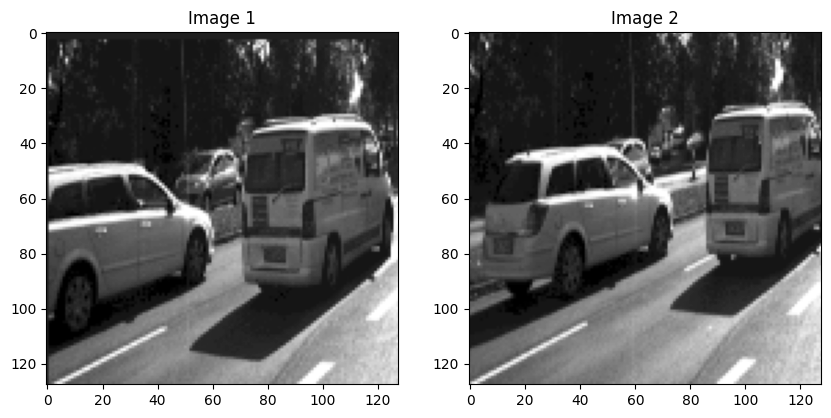

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the algorithms
def sum_of_squared_differences(img1, img2):
    return np.sum((img1 - img2) ** 2)

import numpy as np

def sum_of_robust_differences(img1, img2):
    # Ensure the inputs are numpy arrays
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)

    # Check if shapes are compatible
    if img1.shape != img2.shape:
        raise ValueError("Input images must have the same dimensions")

    # Calculate the absolute differences
    abs_diff = np.abs(img1 - img2)

    # To prevent log(0) which leads to -inf, we can handle the scenario.
    # A small epsilon value can be added; alternatively, filter out zero differences.
    epsilon = 1e-10  # Very small value to avoid log(0)
    robust_diff = np.log(1 + abs_diff + epsilon)  # Add epsilon to avoid log(0)

    return np.sum(robust_diff)

# Example usage
# img1 and img2 should be numpy arrays of the same shape, e.g., images.
def sum_of_absolute_differences(img1, img2):
    return np.sum(np.abs(img1 - img2))

# Load two images to compare
def load_and_preprocess_image(image_path, size=(128, 128)):
    # Read the image
    # Check if the file exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Check if image loading was successful
    if img is None:
        raise ValueError(f"Could not load image: {image_path}")
    # Resize the image
    img_resized = cv2.resize(img, size)
    return img_resized

# Example usage
if __name__ == "__main__":
    # Path to images
    img1_path = 'image-1.png'  # Replace with your image path
    img2_path = 'image-2.png'  # Replace with your image path

    # Load images
    img1 = load_and_preprocess_image(img1_path)
    img2 = load_and_preprocess_image(img2_path)

    # Ensure images have the same dimensions
    assert img1.shape == img2.shape, "Images must have the same dimensions!"

    # Compute the metrics
    ssd = sum_of_squared_differences(img1, img2)
    srd = sum_of_robust_differences(img1, img2)
    sad = sum_of_absolute_differences(img1, img2)

    # Print results
    print(f"Sum of Squared Differences (SSD): {ssd}")
    print(f"Sum of Robust Differences (SRD): {srd}")
    print(f"Sum of Absolute Differences (SAD): {sad}")

    # Display the images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Image 1")
    plt.imshow(img1, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title("Image 2")
    plt.imshow(img2, cmap='gray')
    plt.show()

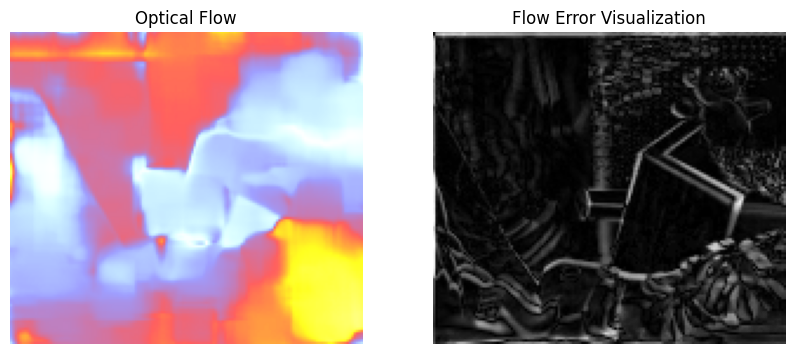

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the two images (ensure they are in grayscale)
img1 = cv2.imread('/content/image1.png', cv2.IMREAD_GRAYSCALE)  # First image
img2 = cv2.imread('/content/image2.png', cv2.IMREAD_GRAYSCALE)  # Second image

# Validate image shapes
if img1 is None or img2 is None:
    raise ValueError("One of the images could not be loaded. Check the file paths.")

# Resize img2 to match img1's dimensions
img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

# Now, the images should have the same dimensions dimensions")

# Compute optical flow using Farneback method
flow = cv2.calcOpticalFlowFarneback(img1, img2, None, 0.5, 3, 15, 3, 5, 1.2, 0)

# Prepare to visualize the flow
h, w = img1.shape
# Calculate magnitude and angle
magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

# Normalize the magnitude for visualization
magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

# Create a blank image for visualization
optical_flow_vis = np.zeros((h, w, 3), dtype=np.uint8)

# Assign colors based on direction and magnitude.
# Here we use a colormap to enhance visibility
for i in range(h):
    for j in range(w):
        # Calculate RGB colors based on the angle
        if magnitude[i, j] > 0:  # Avoid zero division
            color = cv2.applyColorMap(np.array([[magnitude[i, j]]], dtype=np.uint8), cv2.COLORMAP_JET)[0][0]
            optical_flow_vis[i, j] = color * (magnitude[i, j] / 255)  # Scale by magnitude

# Optionally, invert the colors for effect (like in reference image)
optical_flow_vis = 255 - optical_flow_vis

# Visualize flow error as the difference between images
flow_error = cv2.absdiff(img1, img2)

# Plot results
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title('Optical Flow')
plt.imshow(optical_flow_vis)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Flow Error Visualization')
plt.imshow(flow_error, cmap='gray')  # Visualize error as difference
plt.axis('off')

plt.show()

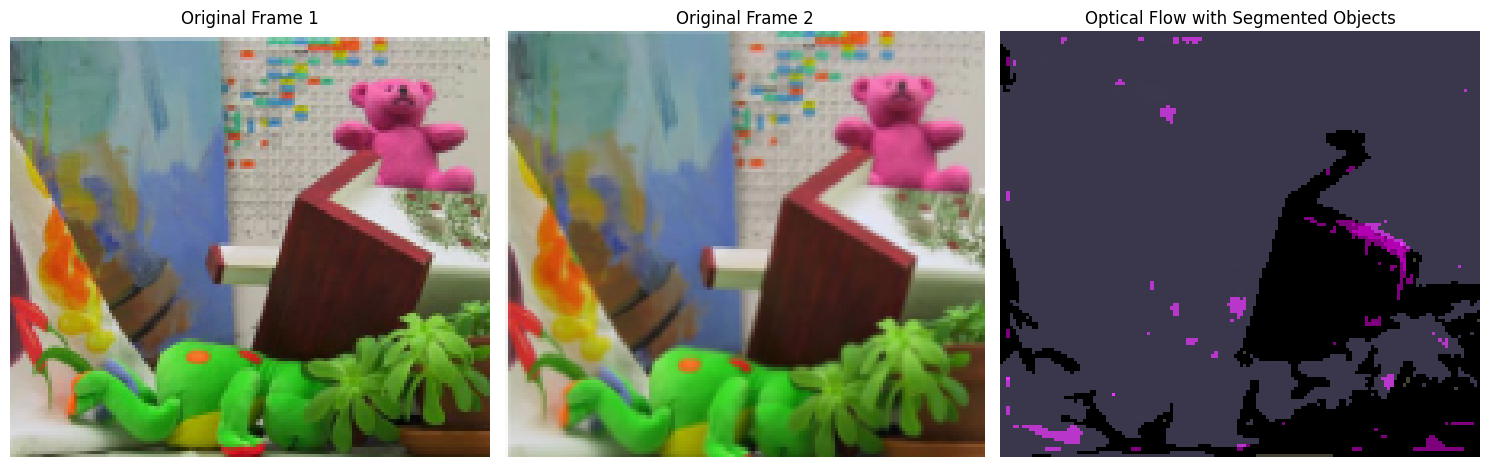

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def schefflera_gt_flow(img1, img2, window_size=5):
    """
    Compute optical flow using Schefflera GT (gradient tensor) method.
    Args:
        img1: First image (grayscale).
        img2: Second image (grayscale).
        window_size: Size of the window for averaging gradients.
    Returns:
        flow: Optical flow (2D vector field) as (h, w, 2) array.
    """
    # Calculate image gradients
    Ix = cv2.Sobel(img1, cv2.CV_64F, 1, 0, ksize=3)  # Gradient in x-direction
    Iy = cv2.Sobel(img1, cv2.CV_64F, 0, 1, ksize=3)  # Gradient in y-direction
    It = img2.astype(np.float64) - img1.astype(np.float64)  # Temporal gradient

    # Initialize flow arrays
    u = np.zeros_like(img1)  # Flow in x
    v = np.zeros_like(img1)  # Flow in y

    # Define window parameters
    half_window = window_size // 2

    # Iterate over each pixel
    for y in range(half_window, img1.shape[0] - half_window):
        for x in range(half_window, img1.shape[1] - half_window):
            # Extract window gradients
            Ix_window = Ix[y - half_window : y + half_window + 1, x - half_window : x + half_window + 1].flatten()
            Iy_window = Iy[y - half_window : y + half_window + 1, x - half_window : x + half_window + 1].flatten()
            It_window = It[y - half_window : y + half_window + 1, x - half_window : x + half_window + 1].flatten()

            # Form gradient tensor
            A = np.stack((Ix_window, Iy_window), axis=1)
            b = -It_window

            # Solve using least squares: (A.T A)u = A.T b
            ATA = np.dot(A.T, A)
            ATb = np.dot(A.T, b)

            # Check if ATA is invertible
            if np.linalg.det(ATA) > 1e-5:
                flow_vector = np.linalg.solve(ATA, ATb)
                u[y, x] = flow_vector[0]
                v[y, x] = flow_vector[1]

    # Combine u and v into a single flow field
    flow = np.stack((u, v), axis=-1)
    return flow

def segment_objects(img):
    """
    Segment objects in the image using simple thresholding and contour detection.
    Args:
        img: Input image (grayscale).
    Returns:
        segmented_image: Image with segmented objects marked with distinct labels.
        contours: Contours of the detected objects.
    """
    # Convert to grayscale (if not already) and apply binary thresholding
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank mask to draw the segmented objects
    segmented_image = np.zeros_like(img)

    # Define light blue and light pink colors
    light_blue = (173, 216, 230)  # Light blue color (BGR)
    light_pink = (255, 182, 193)  # Light pink color (BGR)

    # Assign light colors (blue and pink) to each object and draw contours
    for i, contour in enumerate(contours):
        # Alternate between light blue and light pink for each object
        color = light_blue if i % 2 == 0 else light_pink
        cv2.drawContours(segmented_image, [contour], -1, color, thickness=cv2.FILLED)

    return segmented_image, contours

def visualize_flow_with_objects(flow, img, contours):
    """
    Visualize optical flow on top of segmented objects with distinct colors.
    Args:
        flow: The optical flow field (h, w, 2).
        img: The original image with segmented objects.
        contours: Contours of the segmented objects.
    """
    # Ensure the flow is of type float32 for compatibility
    flow = flow.astype(np.float32)

    # Compute magnitude and angle of flow
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Normalize magnitude to 0-255 for better visualization
    normalized_magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

    # Create a flow visualization image with a light pink hue
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    hsv[..., 0] = 150  # Hue for pink
    hsv[..., 1] = 255  # Saturation at maximum
    hsv[..., 2] = cv2.convertScaleAbs(normalized_magnitude)  # Value: flow intensity

    # Convert HSV to BGR for visualization
    flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Create an empty image to overlay flow and objects
    overlay_image = np.zeros_like(img)

    # For each object (contour), assign a distinct color and blend the flow
    for i, contour in enumerate(contours):
        # Alternate between light blue and light pink for each object
        color = (173, 216, 230) if i % 2 == 0 else (255, 182, 193)
        cv2.drawContours(overlay_image, [contour], -1, color, thickness=cv2.FILLED)

    # Now fill the background with light blue and light pink for segmented objects
    background = np.zeros_like(img)
    for i, contour in enumerate(contours):
        # Use light blue and light pink for the background
        color = (173, 216, 230) if i % 2 == 0 else (255, 182, 193)
        cv2.drawContours(background, [contour], -1, color, thickness=cv2.FILLED)

    # Blend the flow visualization and the background
    alpha = 0.7
    beta = 1 - alpha
    final_output = cv2.addWeighted(flow_bgr, alpha, background, beta, 0)

    return final_output

# Main script
if __name__ == "__main__":
    # Load the two images
    img1_path = '/content/image1.png'
    img2_path = '/content/image2.png'
    img1 = cv2.imread(img1_path, cv2.IMREAD_COLOR)  # Load in color for visualization
    img2 = cv2.imread(img2_path, cv2.IMREAD_COLOR)  # Load in color for visualization

    # Validate image loading
    if img1 is None or img2 is None:
        raise ValueError("One of the images could not be loaded. Check the file paths.")

    # Resize the second image to match the first image
    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

    # Convert images to grayscale for optical flow computation
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow using the Schefflera GT method
    flow = schefflera_gt_flow(gray1, gray2)

    # Segment objects in the first image
    segmented_image, contours = segment_objects(img1)

    # Visualize optical flow with the segmented objects
    flow_with_objects = visualize_flow_with_objects(flow, img1, contours)

    # Plot the results
    plt.figure(figsize=(15, 8))

    # Display the original Frame 1
    plt.subplot(1, 3, 1)
    plt.title('Original Frame 1')
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Display the original Frame 2
    plt.subplot(1, 3, 2)
    plt.title('Original Frame 2')
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Display the optical flow visualization with segmented objects
    plt.subplot(1, 3, 3)
    plt.title('Optical Flow with Segmented Objects')
    plt.imshow(cv2.cvtColor(flow_with_objects, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()


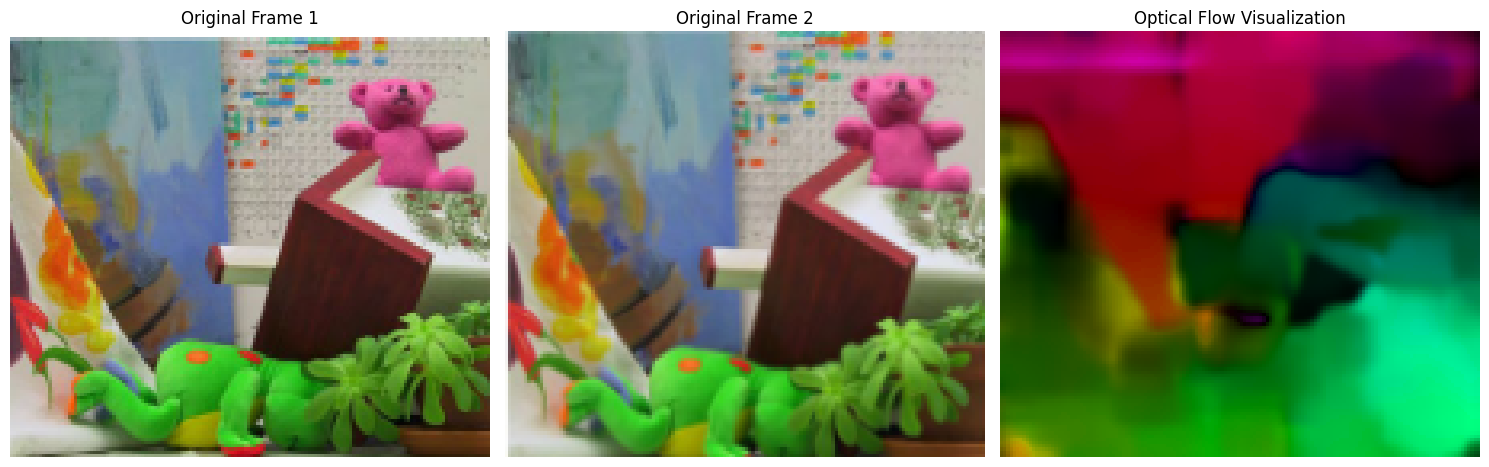

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def calculate_realistic_synthetic_flow(img1, img2):
    """
    Calculate optical flow based on synthetic imagery principles.
    """
    # Convert images to grayscale if they are not
    if len(img1.shape) == 3:
        img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    else:
        img1_gray = img1

    if len(img2.shape) == 3:
        img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    else:
        img2_gray = img2

    # Use Farneback for dense optical flow
    flow = cv2.calcOpticalFlowFarneback(img1_gray, img2_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    # Post-process the flow to enhance realism
    # Smooth the flow field for continuity
    flow[..., 0] = cv2.GaussianBlur(flow[..., 0], (5, 5), 0)
    flow[..., 1] = cv2.GaussianBlur(flow[..., 1], (5, 5), 0)

    # Scale the magnitude to reflect realistic motion
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

    return flow, magnitude, angle


def visualize_flow(flow, magnitude, angle):
    """
    Visualize the optical flow as a color-coded image.
    """
    h, w = flow.shape[:2]

    # Create an HSV image
    hsv = np.zeros((h, w, 3), dtype=np.float32)
    hsv[..., 0] = (angle * 180 / np.pi / 2)  # Hue: direction of flow
    hsv[..., 1] = 255  # Saturation
    hsv[..., 2] = cv2.convertScaleAbs(magnitude)  # Value: normalized magnitude

    # Convert HSV to BGR for visualization
    flow_color = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

    return flow_color


# Main script
if __name__ == "__main__":
    # Load the two images
    img1_path = '/content/image1.png'
    img2_path = '/content/image2.png'

    img1 = cv2.imread(img1_path, cv2.IMREAD_COLOR)  # Load as color image
    img2 = cv2.imread(img2_path, cv2.IMREAD_COLOR)

    # Validate image loading
    if img1 is None or img2 is None:
        raise ValueError("One of the images could not be loaded. Check the file paths.")

    # Resize img2 to match img1
    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

    # Calculate optical flow
    flow, magnitude, angle = calculate_realistic_synthetic_flow(img1, img2)

    # Visualize the optical flow
    flow_visualization = visualize_flow(flow, magnitude, angle)

    # Plot the results
    plt.figure(figsize=(15, 8))

    # Display the original Frame 1
    plt.subplot(1, 3, 1)
    plt.title('Original Frame 1')
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Display the original Frame 2
    plt.subplot(1, 3, 2)
    plt.title('Original Frame 2')
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Display the optical flow visualization
    plt.subplot(1, 3, 3)
    plt.title('Optical Flow Visualization')
    plt.imshow(cv2.cvtColor(flow_visualization, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()
